## Step 1. 스티커 구하기 or 만들기

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import dlib

print("🌫🛸")

🌫🛸


(480, 640, 3)


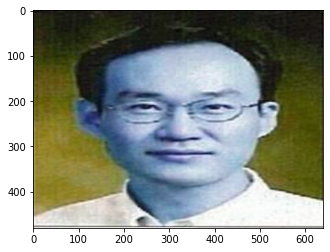

In [2]:
my_image_path = os.getenv('HOME')+'/aiffel/Exploration/03_camera_sticker/images/image.png'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 480))    # 640x360의 크기로 Resize
print(img_bgr.shape)
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

## Step 2. 얼굴 검출 & 랜드마크 검출 하기

### 얼굴 검출

rectangles[[(170, 99) (491, 420)]]


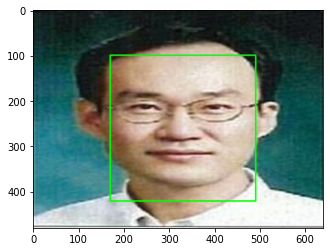

In [3]:

detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)  # 사각형 도형 그리기

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### 랜드마크 검출

In [4]:
model_path = os.getenv('HOME')+'/aiffel/Exploration/03_camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


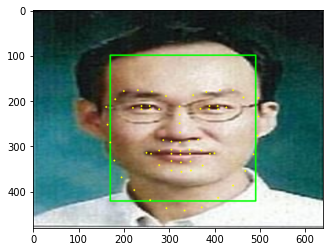

In [5]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow 원 그리기(노란점그리기)  -1옵션 채우기

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## Step 3. 스티커 적용 위치 확인하기

### 스티커 위치와 크기

볼은 '턱'(2), '눈'(36), '입'(48), '코'(30) 사이에 있다.     

In [6]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1] 
    w = (landmark[30][0] - landmark[2][0])*2  # 코와 턱의 x축 차이의 두배로   왼쪽 이동
    h = landmark[48][1] - landmark[36][1]     # 입과 눈의 y축 차이로          위로 이동
    print ('\n코(30번)의 위치 (x,y) : (%d,%d)'%(x,y))
    print ('사각형의 넓이와 높이(w,h) : (%d,%d)'%(w,h))

(324, 269)

코(30번)의 위치 (x,y) : (324,269)
사각형의 넓이와 높이(w,h) : (308,99)


### 스티커 파일 불러옴

In [7]:
sticker_path = os.getenv('HOME')+'/aiffel/Exploration/03_camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h)) # 스티커 이미지 크기를 사각형 크기로 조정
print (img_sticker.shape)

(99, 308, 3)


In [8]:
# 스티커의 시작점을 잡기 위한 좌표조정. 좌상단점을 기준으로 그림.
# 코를 중심으로 놓았기 때문에 폭과 높이의 각 절반만금 위와 좌측으로 이동
refined_x = x - w//2   # left 넓이의 절반만큼 왼쪽으로 이동한 지점에서 스티커 출력
refined_y = y - h//2   # top  높이의 절반만큼 위쪽으로 이동한 지점에서 스티커 출력
print ('스티커 이미지 시작점 (x,y) : (%d,%d)'%(refined_x, refined_y))

스티커 이미지 시작점 (x,y) : (170,220)


## Step 4. 스티커 적용하기

### 작업이미지(img_show)에 스티커 부착

- sticker_area는 (170, 220)에서 (319, 478) 범위이다.   
- 스티커 이미지에서 사용할 부분은 검정색(255)을 사용한다. 따라서 np.where를 통해 img_sticker==255인 부분은 sticker_area로 사용하고 그렇지 않은 영역은 img_area로 사용한다.

In [9]:
sticker_area = img_show[refined_y:img_sticker.shape[0]+refined_y, refined_x:img_sticker.shape[1]+refined_x]
img_show[refined_y:img_sticker.shape[0]+refined_y, refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

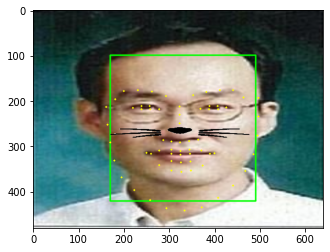

In [10]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 원본이미지(img_bgr)에 스티커 부착

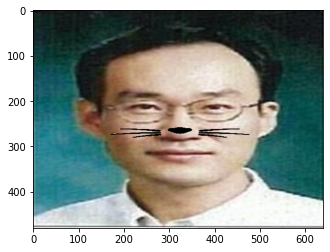

In [11]:
sticker_area = img_bgr[refined_y:img_sticker.shape[0]+refined_y, refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:img_sticker.shape[0]+refined_y, refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

1. 자기만의 카메라앱 기능 구현을 완수하였다.  
원본에 스티커 사진이 정상적으로 합성되었다.  
    
2. 스티커 이미지를 정확한 원본 위치에 반영하였다.     
정확한 좌표계산을 통해 고양이 수염의 위치가 원본 얼굴에 잘 어울리게 출력되었다.  

3. 카메라 스티커앱을 다양한 원본이미지에 적용했을 때의 문제점을 체계적으로 분석하였다.  
얼굴각도, 이미지 밝기, 촬영거리 등 다양한 변수에 따른 영향도를 보고서에 체계적으로 분석하였다.

## 원본 이미지와 스티커 이미지를 합성하는 방법

- 지금까지 살펴본 것은 두 개의 이미지를 겹쳐놓은 것이다. 다른 방법으로는 각 요소의 값들을 합산하는 이미지 합성 기법이 있다. 이를 위해 opencv의 cv2.addWeighted()를 사용하여 보도록 하겠다.

인물 이미지의 모양(높이,폭,색) :  (480, 640, 3)
스티커 이미지의 모양(높이,폭,색) :  (480, 640, 3)


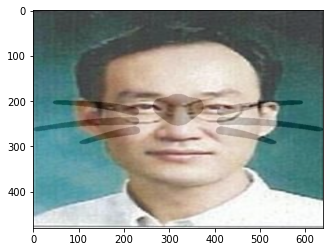

In [14]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

my_image_path = os.getenv('HOME')+'/aiffel/Exploration/03_camera_sticker/images/image.png'
sticker_path = os.getenv('HOME')+'/aiffel/Exploration/03_camera_sticker/images/cat-whiskers.png'

img1 = cv2.imread(my_image_path)
img1 = cv2.resize(img1, (640,480))
print('인물 이미지의 모양(높이,폭,색) : ',img1.shape)
img2 = cv2.imread(sticker_path)
img2 = cv2.resize(img2, (640,480))
print('스티커 이미지의 모양(높이,폭,색) : ',img2.shape)

dst = cv2.addWeighted(img1, 0.8, img2, 0.2, 0)  # 인물이미지 0.8,  스티커이미지 0.2
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
plt.show()

## 작업 분석

￭ [분석1] landmark 68개 점을 확인해보면, 5~13번(턱선)이 지나치게 아래에 찍혀 있다. 원인과 해결책을 찾고 싶었으나 보유한 정보가 부족해 향후 과제로 남겨둠.   
  
￭ [분석2] 두 이미지 합성은 가중치를 인물이미지 0.8, 스티커 이미지 0.2를 두어 적당히 흐릿한 이미지로 만들어졌지만 위치가 왠지 부자연스럽다. 이것은 두 이미지의 크기를 같아야 하는 한계 때문에 발생하는 문제다. 이것을 극복하는 데는 스티커 이미지의 크기를 작게하고 위 아래의 공간을 빈공백으로 만드는 기법정보를 확보하면 가능하리라 생각한다.